### Digit Recognizer

In [4]:
import os
import cv2
import copy
import torch
import random
import argparse

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models

from pathlib import Path
from scipy import ndimage
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms


%reload_ext autoreload
%autoreload 2
%matplotlib inline

### Define data loaders

In [5]:
train_ds = datasets.MNIST('../data', train=True, download=True, 
                       transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

test_ds = datasets.MNIST('../data', train=False, download=True, 
                       transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

Processing...
Done!


In [6]:
batch_size = 64
kwargs = {'num_workers': 1, 'pin_memory': True} 

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False, **kwargs)

### Example Images

In [8]:
def show(img, title=None):
    plt.imshow(img, interpolation='none', cmap="gray")
    if title is not None: plt.title(title)

In [7]:
train_dl = iter(train_loader)
x, y = next(train_dl)

torch shape:  torch.Size([64, 1, 28, 28]) torch.Size([64])
numpy shape:  (64, 1, 28, 28)


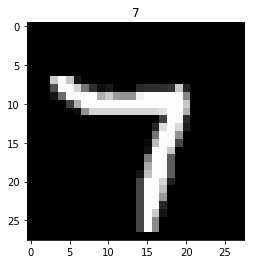

In [14]:
print("torch shape: ", x.shape, y.shape)

# first from torch to numpy
X = x.numpy(); Y = y.numpy()
print("numpy shape: ", X.shape)

show(X[0][0], Y[0])

In [ ]:
class MNet(nn.Module):
    def __init__(self):
        super(MNet, self).__init__()
        self.top_model = nn.Sequential(nn.Linear(28*28, M),
                                       nn.ReLU(),
                                       nn.Linear(M, M - 120),
                                       nn.ReLU(),
                                       nn.Linear(M - 120, M - 240),
                                       nn.ReLU(),
                                       nn.Linear(M - 240, 10))
        
#     def forward(self, x):
#         x = F.relu(self.top_model(x))
#         # x = nn.AdaptiveAvgPool2d((1,1))(x)
#         x = x.view(x.shape[0], -1) # flattening 
#         #x = nn.Dropout(0.2)(x)
#         x = self.bn1(x)
#         x = F.relu(self.fc1(x))
#         #x = nn.Dropout(0.2)(x)
#         x = self.bn2(x)
#         x = self.fc2(x)
#         return x

In [16]:
# for the number of neurons in the hidden unit, inspired by advanced ML notebooks
def get_model(M = 300):
    net = nn.Sequential(nn.Linear(28*28, M),
                        nn.ReLU(),
                        nn.Linear(M, M - 120),
                        nn.ReLU(),
                        nn.Linear(M - 120, M - 240),
                        nn.ReLU(),
                        nn.Linear(M - 240, 10))
    return net #.cuda()

In [30]:
def train_model(train_loader, test_loader, num_epochs, model, optimizer):
    for epoch in range(num_epochs):
        model.train()
        sum_loss = 0.0
        total = 0
        for i, (images, labels) in enumerate(train_loader):  
            batch = images.shape[0] # size of the batch
            # Convert torch tensor to Variable, change shape of the input
            images = images.view(-1, 28*28)  #.cuda()
            # labels = Variable(labels).cuda()
        
            # Forward + Backward + Optimize
            optimizer.zero_grad()  # zero the gradient buffer
            outputs = model(images)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()
        
            total += batch
            sum_loss += batch * loss.data[0]
            #if (i+1) % 100 == 0:
             #   print ('Epoch [%d/%d], Loss: %.4f' 
              #     %(epoch+1, num_epochs, sum_loss/total))
                
        train_loss = sum_loss/total
        print('Epoch [%d/%d], Loss: %.4f' %(epoch+1, num_epochs, train_loss))
        val_acc, val_loss = model_accuracy_loss(model, test_loader)
        print('Epoch [%d/%d], Valid Accuracy: %.4f, Valid Loss: %.4f' %(epoch+1, num_epochs, val_acc, val_loss))
    return val_acc, val_loss, train_loss

In [31]:
def model_accuracy_loss(model, test_loader):
    model.eval()
    correct = 0
    sum_loss = 0.0
    total = 0
    for images, labels in test_loader:
        images = images.view(-1, 28*28)  #.cuda()
        # labels = Variable(labels)  #.cuda()
        outputs = model(images)
        _, pred = torch.max(outputs.data, 1)
        loss = F.cross_entropy(outputs, labels)
        sum_loss += labels.size(0)*loss.data[0]
        total += labels.size(0)
        correct += pred.eq(labels.data).cpu().sum()
    return 100 * correct / total, sum_loss/ total

In [22]:
net = get_model()
learning_rate = 0.01
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
model_accuracy_loss(net, test_loader)

/Users/taylorjames/anaconda/envs/DL-2018/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  if sys.path[0] == '':


(tensor(8), tensor(2.3041))

### Training Round 4
(Round 1, 2, and 3 were done in same cell)

In [33]:
train_model(train_loader, test_loader, num_epochs=10, model=net, optimizer=optimizer)

/Users/taylorjames/anaconda/envs/DL-2018/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch [1/10], Loss: 0.1411


/Users/taylorjames/anaconda/envs/DL-2018/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  if sys.path[0] == '':


Epoch [1/10], Valid Accuracy: 96.0000, Valid Loss: 0.1790
Epoch [2/10], Loss: 0.1352
Epoch [2/10], Valid Accuracy: 96.0000, Valid Loss: 0.1877
Epoch [3/10], Loss: 0.1279
Epoch [3/10], Valid Accuracy: 96.0000, Valid Loss: 0.1604
Epoch [4/10], Loss: 0.1201
Epoch [4/10], Valid Accuracy: 96.0000, Valid Loss: 0.2368
Epoch [5/10], Loss: 0.1100
Epoch [5/10], Valid Accuracy: 96.0000, Valid Loss: 0.1544
Epoch [6/10], Loss: 0.1303
Epoch [6/10], Valid Accuracy: 96.0000, Valid Loss: 0.1949
Epoch [7/10], Loss: 0.1231
Epoch [7/10], Valid Accuracy: 96.0000, Valid Loss: 0.1602
Epoch [8/10], Loss: 0.1172
Epoch [8/10], Valid Accuracy: 96.0000, Valid Loss: 0.1852
Epoch [9/10], Loss: 0.1115
Epoch [9/10], Valid Accuracy: 96.0000, Valid Loss: 0.2115
Epoch [10/10], Loss: 0.0963
Epoch [10/10], Valid Accuracy: 96.0000, Valid Loss: 0.1728


(tensor(96), tensor(0.1728), tensor(1.00000e-02 *
        9.6310))

### Save model for later use 

In [42]:
def save_model(m, p): 
    torch.save(m.state_dict(), p)
    
def load_model(m, p): 
    m.load_state_dict(torch.load(p))

In [43]:
save_model(net, "nn_digit.p")

In [44]:
net2 = get_model()

In [45]:
! ls

Digit-Recognizer             digit-recognizer-copy
Digit_NN.ipynb               logistic_regression_torch.py
README.md                    nn_digit.p
dig_rec_scratch.ipynb        webcam_capture.py


### Sample use of model to predict on images

In [46]:
load_model(net2, "nn_digit.p")

In [54]:
output = net2(x[0].view(-1, 28*28))

In [55]:
_, pred = torch.max(output.data, 1)

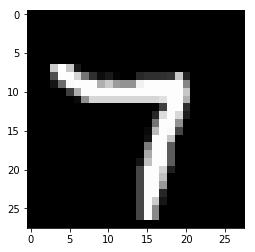

In [59]:
show(x[0].numpy()[0]) 

In [56]:
pred

tensor([ 7])